# Intergalactic Impressions: How to Use Neural Style to Create SpaceX Impressionism

### A Project by Noel McCann

<img src="images/impression_space.png" style="width:550px;height:200px;">

AI is enabling content creation like never before. From LLMs dedicated to writing novels to using algorithms to create Drake songs from scratch, artists and creators are entering a new world of opportunities. Using the artistic style of Paul Gauguin, we will use his art style to reimagine images of SpaceX's Dragon initiative via Neural Style Transfer, an algorithm created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

## This project will:
- Implement the neural style transfer algorithm 
- Generate Gauguin-esque images via the algorithm 
- Define a style cost function & a content cost function
- Enable others to experiment with this tool

## 1. Let's get started!
First, we will run the following code cell to import the necessary packages and dependencies to perform a Neural Style Transfer.

In [2]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
from public_tests import *
%matplotlib inline


## 2. What is Neural Style Transfer, anyway?

Neural Style Transfer is a deep learning optimization technique that is gaining popularity amongst content creators. This transfer merges two images: a <strong>"content" image (C)</strong> and a <strong>"style" image (S)</strong>. Once merged, a <strong>"generated" image (G)</strong> is created, which combines the "content" of image C with the "style" of image S. 

One popular example is a Monet-style depiction of the Louvre. This combines a stock photo of the museum (content image) with the impressionist style of Claude Monet (style image):

<img src="images/louvre_generated.png" style="width:750px;height:200px;">

## 3 - VGG-19

Today, we will use the VGG network from the [original NST white paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at the University of Oxford in 2014. We're using VGG-19, a 19-layer version of the VGG network that has previously been trained on the ImageNet database. 

In [3]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

## 4 - Neural Style Transfer (NST)

We will tackle the Neural Style Transfer (NST) algorithm in three steps:

- First, we'll deal with the content cost function to understand the processing time of the content image
- Second, we'll build the style cost function to understand the processing time of the style image
- Finally, we'll put it all together to get our generated image

<a name='4-1'></a>

#### Approach generated images like Goldilocks

Ideally, the generated image should match the content of its source image. Doing this requires identifying the right layer. Here's a brief rundown of the layer types.

* Shallow layers of a ConvNet tend to detect lower-level features such as edges and simple textures.
* Deep layers tend to detect higher-level features such as more complex textures and object classes. 

#### Choosing a "middle" layer :
The level of layers will impact what is ultimately generated. We don't want generated images that go too deep (further from desired style) nor too shallow (computationally expensive), so let's go right down the middle with our chosen image.

The content image shows a SpaceX Dragon spacecraft flying over Mars.


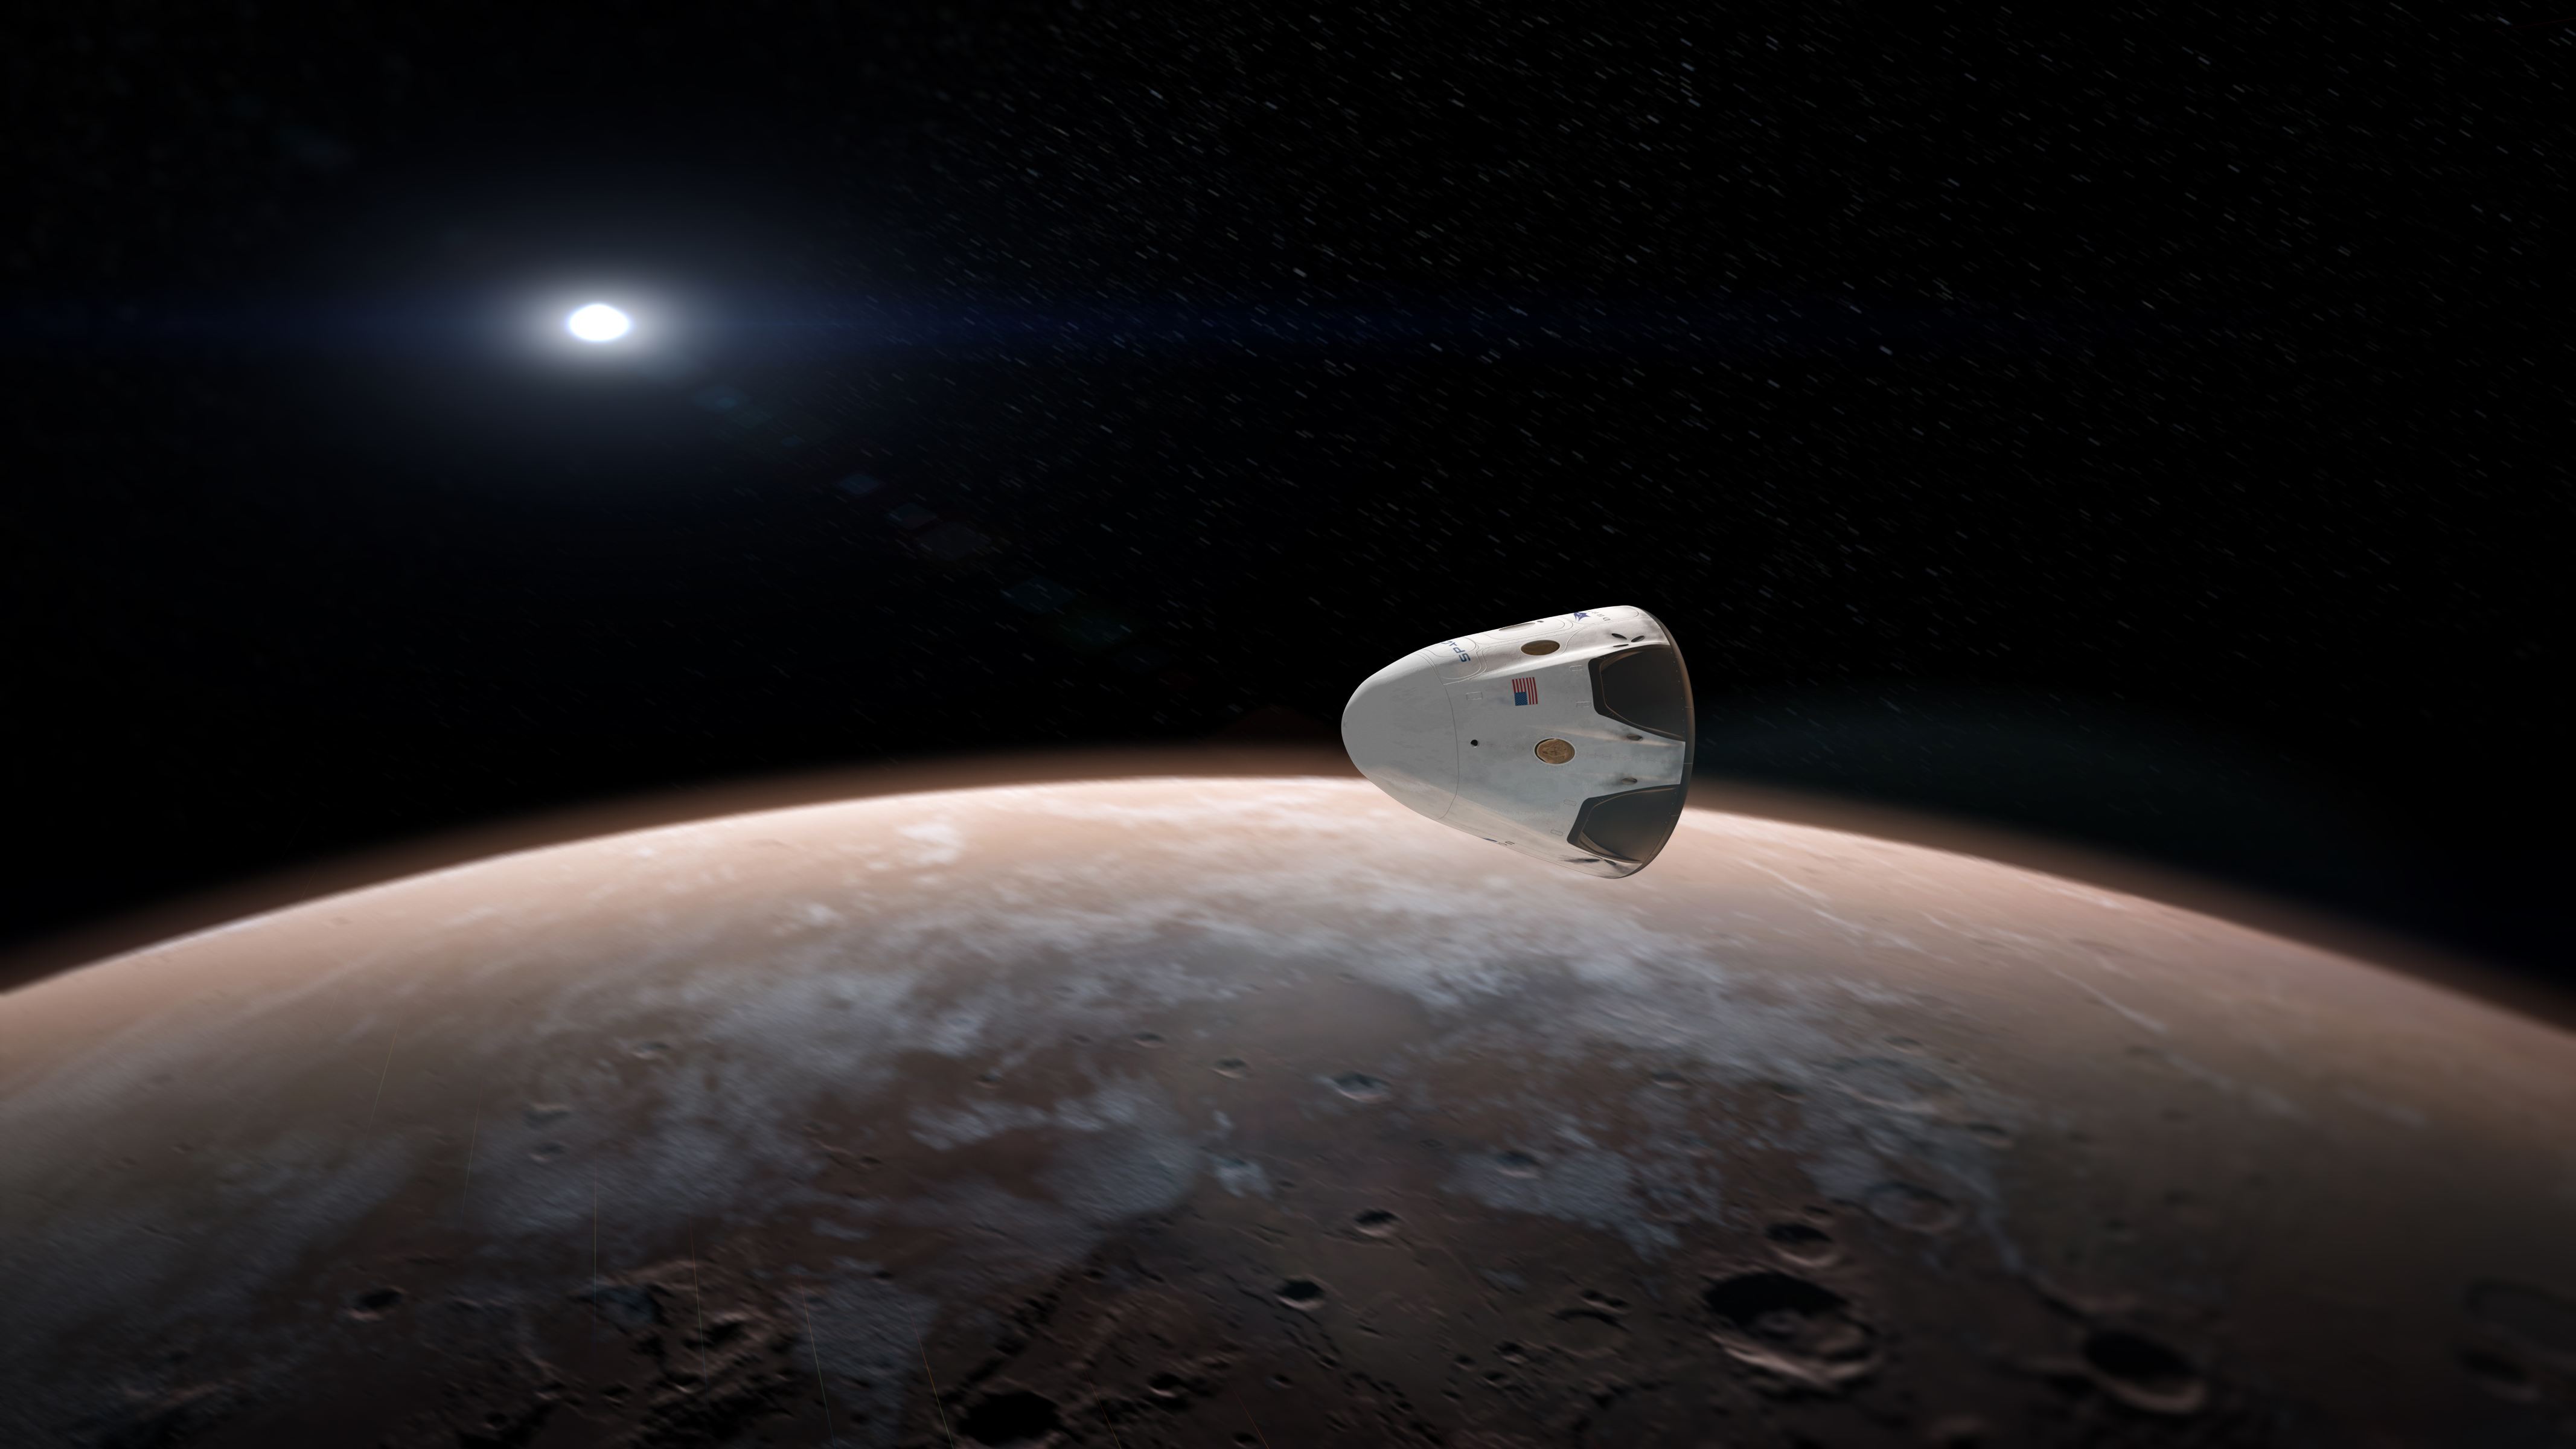

In [4]:
content_image = Image.open("images/6_spacex.jpg")
print("The content image shows a SpaceX Dragon spacecraft flying over Mars.")
content_image

Looks adventrous, doesn't it? Let's see how intensive it'll be to generate an image based on the content image via "content cost". This process will use TensorFlow, specifically its [tf.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [tf.square](https://www.tensorflow.org/api_docs/python/tf/square) and [tf.subtract](https://www.tensorflow.org/api_docs/python/tf/subtract) features.

In [5]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that is being computed
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # Retrieving dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Unrolling our images to make processing more efficient
    a_C_unrolled = tf.transpose(tf.reshape(a_C, shape=[m, -1, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, shape=[m, -1, n_C]))
    
    # Computing the cost
    J_content =  (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    return J_content


In [6]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost([a_C], [a_G])
J_content_0 = compute_content_cost([a_C], [a_C])

print("J_content = " + str(J_content))

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)


The content cost takes a hidden layer activation of the neural network, and measures how different the source and generated images will be. The cost is 7.057 when rounded. Not bad for a first image generator!

### Adding some style

For the running example, we will use the following style image: 

In [ ]:
style_source = Image.open("images/gauguin.jpg")
style_source

Paul Gauguin was famous for his portraits and paintings of everyday life in the French Polynesia. His impressionist paints utilize an experimental use of color, perfect to add a bit of spice to the SpaceX pictures.

To familiarize the NST with his style of art, let's first look into the Gram Matrix, which will share more info related to the active filters and textures used for the art style.

In [ ]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    GA = tf.matmul(A, A, transpose_b=True)
    
    return GA

In [ ]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)

print("GA = \n" + str(GA))

Now we know the level of textures of colors that will be used, let's minimize the distance between the Gram matrix of the style image and the Gram matrix of the generated image. This will ensure the highest possible quality for any pictures we recreate.

In [ ]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W)
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    # Computing the loss
    J_style_layer = (1 / (4 * n_C **2 * (n_H * n_W) **2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))

    
    return J_style_layer

In [ ]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)

print("J_style_layer = " + str(J_style_layer_SG))

## 5. Putting it all together

With one layer fully captured, let's "merge" style costs from other layers. We'll keep it simple by giving each layer equal weight, and the weights add up to 1.

It's time to grab the layer names.

In [ ]:
for layer in vgg.layers:
    print(layer.name)

Let's take a peek into one of those layers.

In [ ]:
vgg.get_layer('block5_conv4').output

We'll now create the style layers, all adding up to 1

In [ ]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

Looks good, doesn't it? Before we get to the meaty stuff, we'll calculate the compute style cost. 

In [ ]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not to be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the array contains the content layer image, which must not to be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer
   
    return J_style

The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. If someone wants to emulate the style source closely, they should try choosing smaller weights for deeper layers and larger weights for the first layers.

With all the costs now calculated, let's bring it home and get the total cost function. The total cost includes both the content cost and the style cost.

In [ ]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha * J_content + beta * J_style

    return J

In [ ]:
J_content = 0.2    
J_style = 0.8
J = total_cost(J_content, J_style)

np.random.seed(1)
print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))


## 6. We have lift off!

With these prechecks out of the way, we should now be able to get our generated images off the ground (no pun intended). 

The tool below enables us to:

1. Load a content image
2. Load a style image
3. Randomly initialize an image to be generated
4. Load the VGG19 model
5. Compute all attached costs
6. Train and optimize all generated images

#### Step 1: Load your content image

Let's load and resize the image we will use for our content.

In [ ]:
content_image = np.array(Image.open("images/6_spacex.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

#### Step 2: Load your style image

Now it's time to load Paul Gauguin as our style.

In [ ]:
style_image =  np.array(Image.open("images/gauguin.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

#### Step 3: Initialize the generated image

This will help us match the content of the generated image more quickly and efficient with that of the content image.

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

#### Step 4: Setup the VGG19 Model 

Remember VGG? It is now coming into play to ensure we can get our image in the style we want.

In [ ]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

We define which layer to use as our content layer here.

In [ ]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [ ]:
content_target = vgg_model_outputs(content_image)  # Content
style_targets = vgg_model_outputs(style_image)     # Style

#### Step 5: Calculating the costs 

Now the model is complete, we should see how efficient or expensive it will be to generate the content we want.

In [ ]:
# Testing content image, with a_C set as the hidden layer.  
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from the same layer.
a_G = vgg_model_outputs(generated_image)

# Content cost
J_content = compute_content_cost(a_C, a_G)

print(J_content)

In [ ]:
# Assign "style" image as input
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Style cost
J_style = compute_style_cost(a_S, a_G)
print(J_style)

Final steps to ensure our generated images appear once run. 

In [ ]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

With all of that set, let's get the transfer learning ready. This is the final step, and it's where the bulk of the artificial intelligence work will kick in.

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.03)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # We will use the precomputed encoded images a_S and a_C to compute a_G

        a_G = vgg_model_outputs(generated_image)
        
        # Style cost
        J_style = compute_style_cost(a_S, a_G)

        # Content cost
        J_content = compute_content_cost(a_C, a_G)
        # Total cost
        J = total_cost(J_content, J_style)  
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    
    return J

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

J1 = train_step(generated_image)
print(J1)

J2 = train_step(generated_image)
print(J2)


#### Step 6: Training Day

The following cell will generate the desired images. This can take a while depending on the PC or Mac you use. I used a MacBook Pro 14-inch (2021) M1 Max 24-Core for the production of this project.

In [ ]:
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 

If it all goes to plan, you will have a generated piece of art! Run the following cell to see the end results.

In [ ]:
# Show the content, style, and finished generated images in one row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

Want to give it a try? Download the file in this GitHub project and add your images to the Images folder. From there, make the following changes in steps 1 and 2:

From: 
content_image = np.array(Image.open("images/6_spacex.jpg").resize((img_size, img_size)))

style_image =  np.array(Image.open("images/gauguin.jpg").resize((img_size, img_size)))

To:

content_image = np.array(Image.open("images/(your content).jpg").resize((img_size, img_size)))

style_image =  np.array(Image.open("(your styl)e.jpg").resize((img_size, img_size)))